Dataset shape: (36067, 4)

Descriptive Statistics:
         Unnamed: 0         label
count  36067.000000  36067.000000
mean   36065.250201      0.512213
std    20762.082682      0.499858
min        0.000000      0.000000
25%    18150.000000      0.000000
50%    36055.000000      1.000000
75%    53905.500000      1.000000
max    72131.000000      1.000000

Label Distribution:
label
1    18474
0    17593
Name: count, dtype: int64


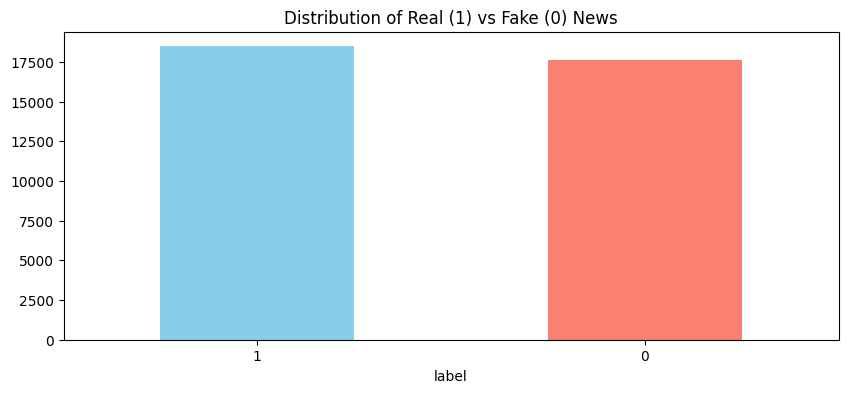


Missing values before cleaning:
Unnamed: 0      0
title         288
text           21
label           0
dtype: int64

Missing values after cleaning:
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
LR: 0.9223 (0.0034)
NB: 0.8367 (0.0034)
RF: 0.9260 (0.0025)


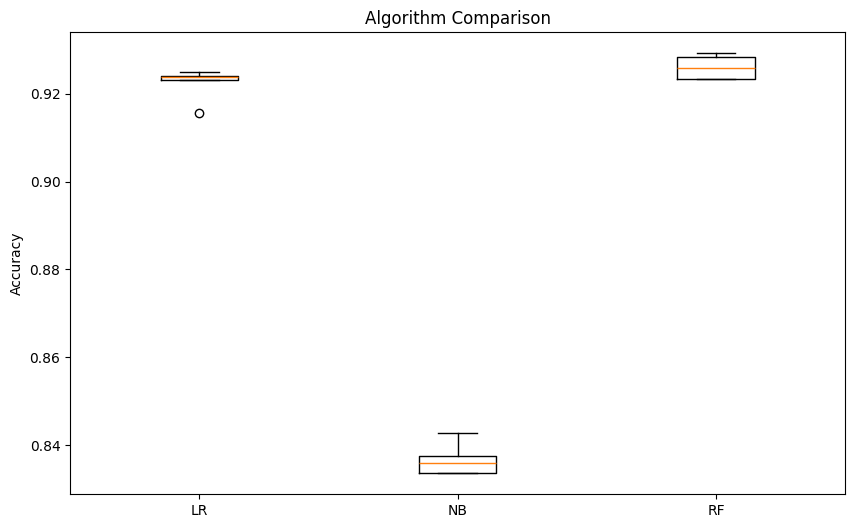


Logistic Regression Test Accuracy: 0.9268736017897091
Random Forest Test Accuracy: 0.9309284116331096

Final Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3509
           1       0.92      0.94      0.93      3643

    accuracy                           0.93      7152
   macro avg       0.93      0.93      0.93      7152
weighted avg       0.93      0.93      0.93      7152


Confusion Matrix:
[[3217  292]
 [ 231 3412]]

Model saved as 'fake_news_model.pkl'

Sample predictions:
'Scientists confirm climate change is real and caus...' - Real news
'Aliens landed in New York yesterday, government co...' - Real news


In [3]:
# 1. Prepare Problem
# a) Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import pickle
import warnings
warnings.filterwarnings('ignore')

# b) Load dataset
df = pd.read_csv('WELFake_Dataset_Half.csv')
print("Dataset shape:", df.shape)

# 2. Summarize Data
# a) Descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())
print("\nLabel Distribution:")
print(df['label'].value_counts())

# b) Data visualizations
plt.figure(figsize=(10, 4))
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Real (1) vs Fake (0) News')
plt.xticks(rotation=0)
plt.show()

# 3. Prepare Data
# a) Data Cleaning
print("\nMissing values before cleaning:")
print(df.isnull().sum())
df = df.dropna().reset_index(drop=True)
print("\nMissing values after cleaning:")
print(df.isnull().sum())

# b) Feature Selection
df = df[['text', 'label']]  # Using only text content and label

# c) Data Transforms
# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X = tfidf.fit_transform(df['text'])
y = df['label']


# 4. Evaluate Algorithms
# a) Split-out validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# b) Test options and evaluation metric
models = []
models.append(('LR', LogisticRegression()))
models.append(('NB', MultinomialNB()))
models.append(('RF', RandomForestClassifier()))
# models.append(('SVM', SVC()))

# +++++1. Model Evaluation and Selection++++++++++++++++
# c) Spot Check Algorithms
results = []
names = []
# 1. Initial Training (Spot-Checking Algorithms)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    # This trains each model (LogisticRegression, MultinomialNB, etc.) using 5-fold cross-validation.
    # The actual training occurs inside cross_val_score().
    
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

# d) Compare Algorithms
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')
plt.show()
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# 5. Improve Accuracy
# a) Algorithm Tuning (using best performing model)
# 2. Training the Best Model (Logistic Regression)
best_model = LogisticRegression(C=1.5, penalty='l2', solver='liblinear')
best_model.fit(X_train, y_train)
# Here, we train the tuned Logistic Regression model on the full training set (X_train, y_train).

# b) Ensembles (Example with Random Forest)
# 3. Training the Ensemble Model (Random Forest)
ensemble_model = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)
ensemble_model.fit(X_train, y_train)
# This trains a Random Forest classifier for comparison.


# Compare performance
print("\nLogistic Regression Test Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))
print("Random Forest Test Accuracy:", accuracy_score(y_test, ensemble_model.predict(X_test)))

# 6. Finalize Model
# a) Predictions on validation dataset
final_model = best_model  # Selecting logistic regression as our final model
y_pred = final_model.predict(X_test)
print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# b) Create standalone model on entire training dataset
# 4. Final Training (Pipeline for Deployment)
full_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('model', LogisticRegression(C=1.5, penalty='l2', solver='liblinear'))
])
full_model.fit(df['text'], df['label'])
# This trains the final pipeline (TF-IDF + Logistic Regression) 
# on the entire dataset (not just X_train), ensuring maximum learning before deployment.

# c) Save model for later use
with open('fake_news_model.pkl', 'wb') as f:
    pickle.dump(full_model, f)
print("\nModel saved as 'fake_news_model.pkl'")

# Demonstration of loading and using the saved model
with open('fake_news_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
# ___________________________4. Enhanced Output________________________________________
sample_news = ["Scientists confirm climate change is real and caused by human activity",
               "Aliens landed in New York yesterday, government covering it up"]
print("\nSample predictions:")
for news in sample_news:
    pred = loaded_model.predict([news])
    print(f"'{news[:50]}...' - {'Real' if pred[0] == 1 else 'Fake'} news")